<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
<h3> This notebook will compute correlations between two neurons in the the Allen Brain Observatory to quantitatively compare their responses to Drifting Gratings </h3>
    
In the last notebook, you noticed that some of the neurons had the same tuning for orientation and temporal frequency. Here we want to look at how similar are these responses. To do this, we will look at how the activity of two similarly tuned neurons are correlated.


### Standard imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

### Allen Brain Observatory set up

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '../data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>We want to compare cell_id 541513979 (the original neuron we looked at) to cell_id 541511905. Again, these two neurons were both recorded in the same session.
    
<p> We will need the function from notebook 1 to get the dff_trace for each of these neurons and the compute_tuning function you wrote in the previous notebook to get the tuning arrays for each of these neurons. Modify this function to return both the cell_response array and the tuning_array.

</div style>

In [4]:
def get_dff_traces_and_stim_table(cell_specimen_id, stimulus): 
    #identify the session for a given cell id and stimulus
    exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], stimuli=[stimulus])
    
    #get the session_id for that session
    session_id = exps[0]['id']
    
    #access the data for that session
    data_set = boc.get_ophys_experiment_data(session_id)
    
    #get the DFF trace for the cell
    timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_specimen_id])
    dff_trace = dff[0,:]
    
    #get the stimulus table for the stimulus
    stim_table = data_set.get_stimulus_table(stimulus)
    
    #return everything
    return (timestamps, dff_trace, stim_table)

Copy and paste your function here:

In [9]:
def compute_tuning(cell_id):
    #get the dff_traces and the stimulus table using the function above
    timestamps, dff_trace, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')
    
    #compute the cell response
    cell_response= np.zeros((len(stim_table),3))
    for i in range(len(stim_table)):
        cell_response[i,0] = stim_table.orientation[i]
        cell_response[i,1] = stim_table.temporal_frequency[i]
        cell_response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()
    
    #get the orivals and tfvals
    all_ori = np.unique(cell_response[:,0])
    orivals = all_ori[np.isfinite(all_ori)]
    tfvals = np.unique(cell_response[:,1])
    tfvals = tfvals[np.isfinite(tfvals)]
    
    #compute the tuning array
    tuning_array = np.empty((8,5))
    for i,tf in enumerate(tfvals):
        tf_trials = cell_response[:,1]==tf
        subset = cell_response[tf_trials]
        for j,ori in enumerate(orivals):
            trials = subset[:,0]==ori
            tuning_array[j,i] = subset[trials,2].mean() 
    
    #plot the heatmap of the tuning array and save it
    plt.imshow(tuning_array)
    plt.xticks(range(5), tfvals)
    plt.yticks(range(8), orivals)
    plt.xlabel("TF")
    plt.ylabel("Direction")
    plt.title("Cell "+str(cell_id))
    plt.show()
    plt.savefig("/results/Cell "+str(cell_id)+".jpg")
    
    return (cell_response, tuning_array)

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 1:** Get the dff_trace for each of these neurons. Call one dff_trace_1 and the other dff_trace_2. </div>

In [16]:
cell_id = 541513979
timestamps, dff_trace_1, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')

In [8]:
cell_id_2 = 541511905
timestamps, dff_trace_2, stim_table = get_dff_traces_and_stim_table(cell_id_2, 'drifting_gratings')

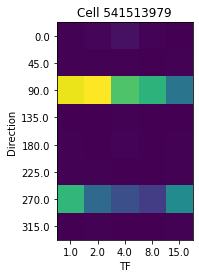

<Figure size 432x288 with 0 Axes>

In [10]:
(cell_response_1, tuning_array_1) = compute_tuning(cell_id)

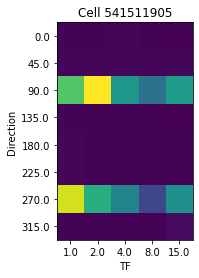

<Figure size 432x288 with 0 Axes>

In [11]:
(cell_response_2, tuning_array_2) = compute_tuning(cell_id_2)

<div style="border-radius: 3px; padding: 10px;  background: #F0FAFF; ">
<h3>Correlations</h3>
<p>
We can compute a correlation coefficient to measure the relationship between two variables - in this case the responses of two different cells. When cell A has a large response, does cell B also have a strong response? 
<p> We will use Pearson correlation coefficient, which is defined as:
    <br>
<img src="correlation_coefficient_formula.svg">
<p> where x and y are the two variables in question. We will use a function from scipy.stats to compute this for us.
<p> If the two variables are positively correlated, a large response from cell A will be matched with a large response in cell B. If they are weakly correlated, the response size of cell A will have no relationship with the response size of cell B. And if they are negatively correlated, cell B will have small responses when cell A has large responses.
<br><img src="pearson-2-small.png">
</div>

Import scipy.stats

In [12]:
import scipy.stats as st

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Let's begin by comparing the tuning arrays of these two neurons. We've already noted that they look very similar. How similar are they? 
    <p> In order to use <b>st.pearsonr</b> we need to turn this two-dimensional array into a one-dimensional array. We use <b>flatten</b> to do this.
    <p> st.pearsonr returns two values, typical notated as r and p. r is the correlation coefficient we want to look at. p is a p-value noting its significance.
</div style>

In [13]:
r,p = st.pearsonr(tuning_array_1.flatten(), tuning_array_2.flatten())
print(r)

0.9347812227928617


Text(0.5, 1.0, 'Tuning array')

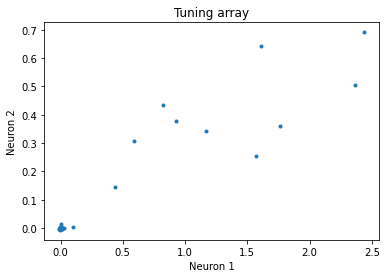

In [37]:
plt.plot(tuning_array_1.flatten(), tuning_array_2.flatten(), '.')
plt.xlabel("Neuron 1")
plt.ylabel("Neuron 2")
plt.title("Tuning array")

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
This is very highly correlated! Indeed we were correct that they have very similar tuning curves.
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 2:** Calculate the correlation coefficient between the cell_response arrays for the two neurons. These are the responses to each trial, before we average the trials for each stimulus condition together.
<p>(Use the last column of cell_response array - this column is already one_dimensional, so you won't need to flatten)
</div>

In [14]:
r,p = st.pearsonr(cell_response_1[:,2], cell_response_2[:,2])
print(r)

0.7640585294224912


Text(0.5, 1.0, 'Trial responses')

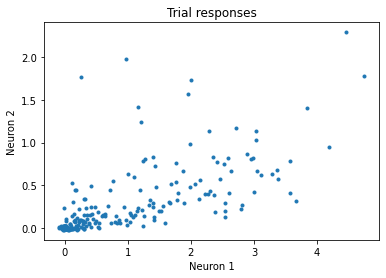

In [38]:
plt.plot(cell_response_1[:,2], cell_response_2[:,2], '.')
plt.xlabel("Neuron 1")
plt.ylabel("Neuron 2")
plt.title("Trial responses")

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 3:** Calculate the correlation coefficient between the dff_trace of the two neurons.
</div>

In [17]:
r,p = st.pearsonr(dff_trace_1, dff_trace_2)
print(r)

0.5628775961334622


Text(0.5, 1.0, 'DF/F Traces')

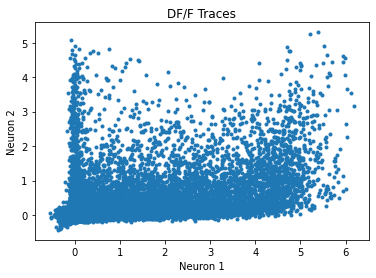

In [39]:
plt.plot(dff_trace_1, dff_trace_2, '.')
plt.xlabel("Neuron 1")
plt.ylabel("Neuron 2")
plt.title("DF/F Traces")

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
What do you notice? Why are these correlation coefficients different?</div>